### Figure 4: QQ plot

In [1]:
import numpy as np
from libpysal.weights import lat2W
import seaborn as sns
import matplotlib.pyplot as plt
import xesmf as xe
# sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))

/user/work/al18709/.conda/envs/aquatic/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
def radMask(index,radius,array):
  a,b = index
  nx,ny = array.shape
  y,x = np.ogrid[-a:nx-a,-b:ny-b]
  mask = x*x + y*y <= radius*radius

  return mask

In [3]:
model = ''
# set mode
mode = 'validation'
print(np.load('/user/home/al18709/work/tc_data_mswep/valid_X.npy').shape)


# load datasets
real = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_real-opt.npy' % (model,mode))[0][:,:,:,0]
pred = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_pred-opt.npy' % (model,mode))[0][:,:,:,0]

pred_cnn = np.load('/user/home/al18709/work/cnn/unet_valid.npy')
pred_dsrnngan = np.load('/user/home/al18709/work/dsrnngan_predictions/validation_pred-opt.npy')[0][:,:,:,0]
pred_vaegan = np.load('/user/home/al18709/work/vaegan/predictions/validation_pred.npy')[0][:,:,:,0]

# pred_ensemble_vaegan = np.load('/user/home/al18709/work/vaegan/predictions/validation_pred.npy')[0]
# pred_ensemble_gan = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_pred-opt.npy' % (model,mode))[0]
inputs = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_input-opt.npy' % (model,mode))[0][:,:,:,0]

# regrid inputs
grid_in = {"lon": np.linspace(0, 100, 10), "lat": np.linspace(0, 100, 10)}
grid_out = {"lon": np.linspace(0, 100, 100), "lat": np.linspace(0, 100, 100)}
regridder = xe.Regridder(grid_in, grid_out, "bilinear")
inputs_hr = regridder(inputs)


(16253, 10, 10)


/user/work/al18709/.conda/envs/aquatic/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


(100, 100)
16253
(16253, 100, 100)
(16253, 100, 100)


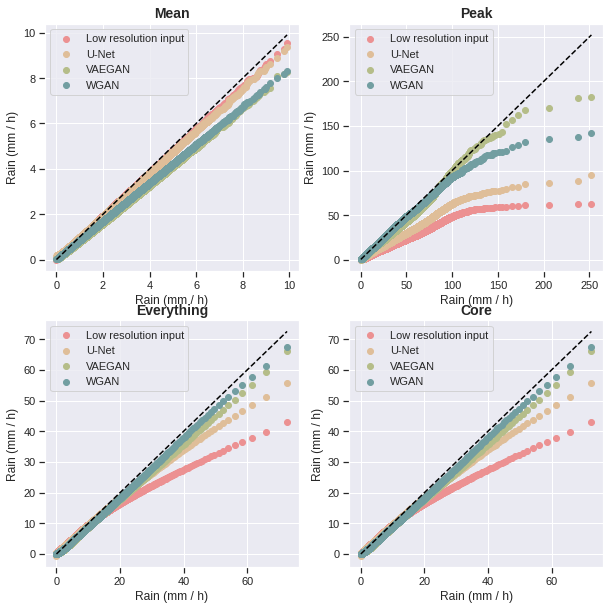

In [5]:




analysis = 'everything'

def plot_qq(ax,analysis,inputs_hr,pred_cnn,pred_vaegan,pred_dsrnngan,real):
	percentiles = np.arange(0,100,0.01)

	if analysis == 'Mean':
		inputs_p = np.percentile(np.mean(np.mean(inputs_hr,axis=1),axis=1), percentiles)
		unet_p = np.percentile(np.mean(np.mean(pred_cnn,axis=1),axis=1), percentiles)
		vaegan_p = np.percentile(np.mean(np.mean(pred_vaegan,axis=1),axis=1), percentiles)
		dsrnngan_p = np.percentile(np.mean(np.mean(pred_dsrnngan,axis=1),axis=1), percentiles)
		real_p = np.percentile(np.mean(np.mean(real,axis=1),axis=1), percentiles)

	elif analysis == 'Peak':
		inputs_p = np.percentile(np.max(np.max(inputs_hr,axis=1),axis=1), percentiles)
		unet_p = np.percentile(np.max(np.max(pred_cnn,axis=1),axis=1), percentiles)
		vaegan_p = np.percentile(np.max(np.max(pred_vaegan,axis=1),axis=1), percentiles)
		dsrnngan_p = np.percentile(np.max(np.max(pred_dsrnngan,axis=1),axis=1), percentiles)
		real_p = np.percentile(np.max(np.max(real,axis=1),axis=1), percentiles)

	elif analysis == 'Everything':
		inputs_p = np.percentile(inputs_hr, percentiles)
		unet_p = np.percentile(pred_cnn, percentiles)
		vaegan_p = np.percentile(pred_vaegan, percentiles)
		dsrnngan_p = np.percentile(pred_dsrnngan, percentiles)
		real_p = np.percentile(real, percentiles)

	elif analysis == 'Core':
		print(inputs_hr[0].shape)
		mask=radMask((50,50),25,inputs_hr[0,:,:])
		n,_,_ = inputs_hr.shape
		mask = np.expand_dims(mask,axis=0)
		mask = np.repeat(mask,n,axis=0)
		print(n)
		print(mask.shape)

		inputs_hr = np.ma.array(inputs_hr, mask=mask)
		print(inputs_hr.shape)
		inputs_p = np.percentile(np.ma.array(inputs_hr, mask=mask), percentiles)
		unet_p = np.percentile(np.ma.array(pred_cnn, mask=mask[:-1]), percentiles)
		vaegan_p = np.percentile(np.ma.array(pred_vaegan, mask=mask), percentiles)
		dsrnngan_p = np.percentile(np.ma.array(pred_dsrnngan, mask=mask), percentiles)
		real_p = np.percentile(np.ma.array(real, mask=mask), percentiles)
	
	ax.scatter(real_p,inputs_p,color='#ec9192')
	ax.scatter(real_p,unet_p,color='#dfbe99')
	ax.scatter(real_p,vaegan_p,color='#b5bd89')
	ax.scatter(real_p,dsrnngan_p,color='#729ea1')
	ax.plot(real_p,real_p,'--',color='black')
	# plt.scatter(real_p[9500],inputs_p[9500],color='white',marker='s')
	ax.legend(['Low resolution input','U-Net','VAEGAN','WGAN'],frameon=True)
	# ax.set_xlim([1, np.max(real_p)])
	# ax.set_ylim([1, np.max(real_p)])
	# ax.set_yscale('log')
	# ax.set_xscale('log')

	ax.set_xlabel('Rain (mm / h)')
	ax.set_ylabel('Rain (mm / h)')
	ax.set_title(analysis,fontsize=14,fontweight='bold')


	return ax

plt.style.use('seaborn-darkgrid')
# plt.rcParams["figure.figsize"] = (10,10)
sns.set_context("notebook")
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=False)
ax1 = plot_qq(axes[0,0],'Mean',inputs_hr,pred_cnn,pred_vaegan,pred_dsrnngan,real)
ax2 = plot_qq(axes[0,1],'Peak',inputs_hr,pred_cnn,pred_vaegan,pred_dsrnngan,real)
ax3 = plot_qq(axes[1,0],'Everything',inputs_hr,pred_cnn,pred_vaegan,pred_dsrnngan,real)
ax4 = plot_qq(axes[1,1],'Core',inputs_hr,pred_cnn,pred_vaegan,pred_dsrnngan,real)

plt.savefig('qq_plot_everything.png',bbox_inches='tight')
plt.show()



In [44]:
# print([ '%.2f' % elem for elem in percentiles])
print('%.2f' % percentiles[7500])
print(np.median(inputs_hr))


75.00
0.83256006


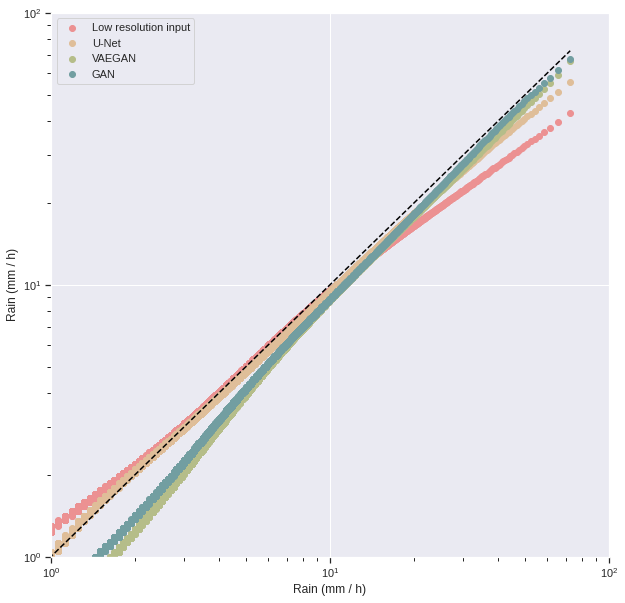

In [36]:
plt.style.use('seaborn-darkgrid')
plt.rcParams["figure.figsize"] = (10,10)
sns.set_context("notebook")
plt.scatter(real_p,inputs_p,color='#ec9192')

plt.scatter(real_p,unet_p,color='#dfbe99')
plt.scatter(real_p,vaegan_p,color='#b5bd89')
plt.scatter(real_p,dsrnngan_p,color='#729ea1')
plt.plot(real_p,real_p,'--',color='black')
# plt.scatter(real_p[9500],inputs_p[9500],color='white',marker='s')
plt.legend(['Low resolution input','U-Net','VAEGAN','WGAN'],frameon=True)
plt.xlim([1, 100])
plt.ylim([1, 100])
plt.yscale('log')
plt.xscale('log')

plt.xlabel('Rain (mm / h)')
plt.ylabel('Rain (mm / h)')
plt.savefig('qq_plot_everything.png',bbox_inches='tight')
plt.show()


# 
# 

In [ ]:
# QQ plot, x axis = obs quantiles, y axis is same and points are model quartiles